In [194]:
import math
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [141]:
def gauss(x, mu, sigma):
    return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sigma**2))

# Comparaison Box-Muler polaire VS cartesien pour la génération de nombre aléatoire gaussien

In [6]:
%timeit random.random()

54.8 ns ± 3.26 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [15]:
def cartesian_bm():
    w = 2
    
    while (w > 1):
        u = (2*random.random()- 1)
        v = (2*random.random()- 1)
        w = u ** 2 + v ** 2 
        
    x = math.sqrt(- 2 * math.log(w) / w) * u
    y = math.sqrt(- 2 * math.log(w) / w) * v
    
    return x, y

In [16]:
cartesian_bm()

(-0.7785853724131186, 0.8937020899611599)

In [18]:
def polar_bm():    
    
    A = random.random()
    B = random.random()
    
    x = math.sqrt(- 2 * math.log(A)) * math.cos(2*math.pi*B)
    y = math.sqrt(- 2 * math.log(B)) * math.sin(2*math.pi*B)
    
    return x,y

In [130]:
np.array(polar_bm()[1])

array(-0.2374405)

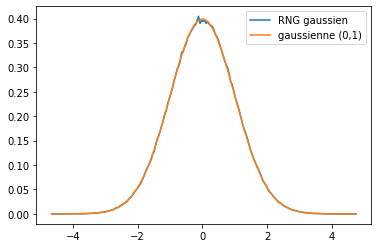

In [142]:
polar_bm()

RNG = np.zeros(1000000)

nb_bins = 200
for i in range(1000000):
    RNG[i] = np.array(polar_bm()[0])
#     RNG[2*i+1] = np.array(polar_bm()[1])

RNG
hist, x = np.histogram(RNG, bins=nb_bins, density=True)
bins_x = (x[:-1]+x[1:])/2
plt.plot(bins_x, hist, label="RNG gaussien")
plt.plot(bins_x, gauss(bins_x, 0, 1), label="gaussienne (0,1)")
plt.legend()

In [116]:
%timeit polar_bm()
%timeit cartesian_bm()

762 ns ± 10.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
890 ns ± 4.31 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [23]:
import cython

In [25]:
%load_ext cython

In [183]:
%%cython

from libc.stdlib cimport rand, RAND_MAX
from libc.math cimport log, sqrt, sin, cos, pi
import cython
import numpy as np


cdef double random_uniform():
    cdef double r = rand()
    return r / RAND_MAX

#######
#Box-muller cartésien
######
@cython.boundscheck(False)
@cython.wraparound(False)
cdef double random_gaussian():
    cdef double x1, x2, w
    
    w = 2.0
    
    while (w >= 1):
        x1 = 2.0 * random_uniform() - 1.0
        x2 = 2.0 * random_uniform() - 1.0
        w = x1*x1 + x2*x2
    
    w = sqrt((-2.0) * log(w) / w) 
    
    return x1 * w

@cython.boundscheck(False)
@cython.wraparound(False)
cdef void assign_random_gaussian_pair(double[:] out, int assign_ix):
    cdef double x1, x2, w
    
    w = 2.0
    
    while (w >= 1):
        x1 = 2.0 * random_uniform() - 1.0
        x2 = 2.0 * random_uniform() - 1.0
        w = x1*x1 + x2*x2
    
    w = sqrt((-2.0) * log(w) / w)
    out[assign_ix] = x1 * w
    out[assign_ix + 1] = x2 * w
    

@cython.boundscheck(False)
@cython.wraparound(False)
def my_gaussian_fast(int n):
    cdef int i
    cdef double[:] result = np.zeros(n, dtype="f8", order="C")
    for i in range(n // 2):
        assign_random_gaussian_pair(result, i*2)
    if n % 2 == 1:
        result[n-1] = random_gaussian()
    return result


####################
#Box-muller polaire
@cython.boundscheck(False)
@cython.wraparound(False)
cdef double polar_bm():
    cdef double A, B, x, y 
    cdef double pi = 3.14159265
    A =  random_uniform()
    B =  random_uniform()
    
    x = sqrt(- 2 * log(A)) * cos(2*pi*B)
    y = sqrt(- 2 * log(A)) * sin(2*pi*B)
    
    return x

@cython.boundscheck(False)
@cython.wraparound(False)
cdef void assign_polar_bm(double[:] out, int assign_ix):    
    cdef double A, B
    A =  random_uniform()
    B =  random_uniform()
    cdef double pi = 3.14159265
    out[assign_ix] = sqrt(- 2 * log(A)) * cos(2*pi*B)
    out[assign_ix + 1] = sqrt(- 2 * log(A)) * sin(2*pi*B)
    
    
@cython.boundscheck(False)
@cython.wraparound(False)
def my_gaussian_fast_polar(int n):
    cdef int i
    cdef double[:] result = np.zeros(n, dtype="f8", order="C")
    for i in range(n // 2):
        assign_polar_bm(result, i*2)
    if n % 2 == 1:
        result[n-1] = polar_bm()
    return result

In [184]:
#cartésien
%timeit my_gaussian_fast(1000000)
#polaire
%timeit my_gaussian_fast_polar(1000000)

23.1 ms ± 493 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
30.4 ms ± 478 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [220]:
# Écart relatif en pourcent
np.abs(30.4  - 23.1 )/ 30.4 * 100

24.013157894736832

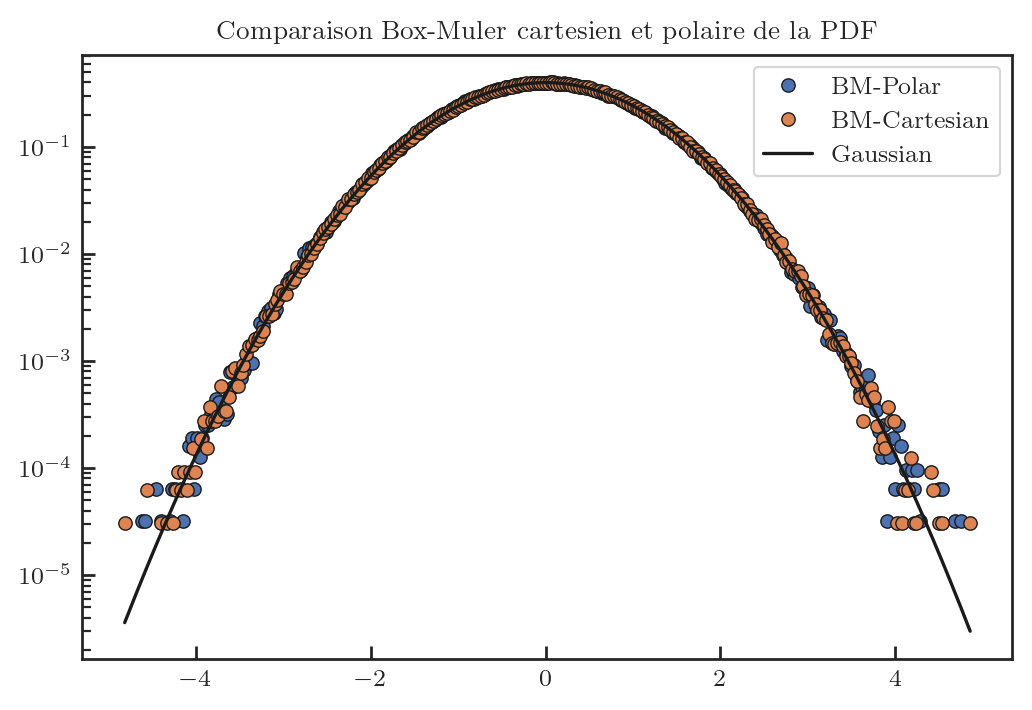

In [219]:
custom_params = {
    "xtick.direction": "in",
    "ytick.direction": "in",
    "lines.markeredgecolor": "k",
    "lines.markeredgewidth": 0.5,
    "figure.dpi": 200,
    "text.usetex": True,
    "font.family": "serif"
}
sns.set_theme(context = "paper", style="ticks", rc=custom_params)

nb_bins = 300
RNG_polar = my_gaussian_fast_polar(1000000)
RNG_cartesian = my_gaussian_fast(1000000)

hist_p, x_p = np.histogram(RNG_polar, bins=nb_bins, density=True)
bins_polar = (x_p[:-1]+x_p[1:])/2

hist_c, x_c = np.histogram(RNG_cartesian, bins=nb_bins, density=True)
bins_cartesian = (x_c[:-1]+x_c[1:])/2

plt.semilogy(bins_polar, hist_p, "o", label="BM-Polar")
plt.plot(bins_cartesian, hist_c, "o", label="BM-Cartesian")
plt.plot(bins_cartesian, gauss(bins_cartesian, 0, 1), "k", label="Gaussian")
plt.title("Comparaison Box-Muler cartesien et polaire de la PDF")
plt.legend()

In [195]:
#Temps pour gaussien de numpy
%timeit np.random.normal(size = 1000000)

19.1 ms ± 485 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Essaie de la méthode Ziggurat

In [75]:
%%cython
# cython: boundscheck=False
# cython: cdivision=True
# cython: wraparound=False

cimport cython
from libc.stdlib cimport rand, srand
from libc.math cimport log, sqrt, cos, round

cimport numpy as np
import time

cdef extern from "stdlib.h":
    cdef int RAND_MAX # Need to this to normalize appropriately to uniform dist

# MT Stuff

cdef unsigned NN = 312
cdef unsigned MM = 156
cdef unsigned long long MATRIX_A = 0xB5026F5AA96619E9ULL
cdef unsigned long long UM = 0xFFFFFFFF80000000ULL
cdef unsigned long long LM = 0x7FFFFFFFULL
cdef unsigned long long mt[312]
cdef unsigned mti = NN + 1
cdef unsigned long long mag01[2]

cdef mt_seed(unsigned long long seed):
    global mt
    global mti
    global mag01
    global NN
    global MATRIX_A
    mt[0] = seed
    for mti in range(1,NN):
        mt[mti] = (6364136223846793005ULL * (mt[mti-1] ^ (mt[mti-1] >> 62)) + mti)

    mag01[0] = 0ULL
    mag01[1] = MATRIX_A
    mti = NN


cdef unsigned long long genrand64():
    cdef int i
    cdef unsigned long long x
    global mag01
    global mti
    global mt
    global NN
    global MM
    global UM
    global LM

    if mti >= NN:
        for i in range(NN-MM):
            x = (mt[i]&UM) | (mt[i+1]&LM)
            mt[i] = mt[i+MM] ^ (x>>1) ^ mag01[int(x&1ULL)]

        for i in range(NN-MM, NN-1):
            x = (mt[i]&UM)|(mt[i+1]&LM)
            mt[i] = mt[i+(MM-NN)] ^ (x>>1) ^ mag01[int(x&1ULL)]

        x = (mt[NN-1]&UM)|(mt[0]&LM)
        mt[NN-1] = mt[MM-1] ^ (x>>1) ^ mag01[int(x&1ULL)]
        mti = 0

    x = mt[mti]
    mti += 1
    x ^= (x >> 29) & 0x5555555555555555ULL
    x ^= (x << 17) & 0x71D67FFFEDA60000ULL
    x ^= (x << 37) & 0xFFF7EEE000000000ULL
    x ^= (x >> 43);

    return x

def py_rand_int():
    return genrand64()

# Functions

# Seed the random number generator
cdef seed_random(unsigned long long seed):
    """
    Seed the C random number generator with the current system time.
    :return: none
    """
    if seed == 0:
        mt_seed(time.time())
    else:
        mt_seed(seed)

def py_seed_random(unsigned long long seed = 0):
    seed_random(seed)



cdef double exponential_rv(double Lambda):
    """
    Generate an exponentially distributed random number
    :param Lambda: (double) the rate parameter of the distribution
    :return: (double) a randomly distributed number
    """
    return -1.0/Lambda* log( uniform_rv() )

def py_exponential_rv(double Lambda):
    return exponential_rv(Lambda)



cdef double uniform_rv():
    """
    Generate a uniform random variable in [0,1]
    :return: (double) a random uniform number in [0,1]
    """
    return (genrand64() >> 11) * (1.0/9007199254740991.0)

def py_uniform_rv():
    return uniform_rv()





cdef double normal_rv(double mean, double std):
    """
    Generate a normal random variable
    :param mean: (double) the mean
    :param std: (double) the standard deviation
    :return:
    """
    cdef double u, v, R, theta
    u = uniform_rv()
    v = uniform_rv()
    R = sqrt(-2*log(u))
    theta = 2*3.141592653589793238462643383279502884*v
    return R*cos(theta)*std + mean

def py_normal_rv(double mean, double std):
    return normal_rv(mean,std)




cdef double gamma_rv(double k, double theta):
    """
    Generate a gamma random variable with parameters (k, theta). The mean is k*theta. Variance k*theta^2. Can think of
     this as adding together k independent exponentials each with mean theta.
    :param k: (double) the first parameter of the gamma distribution. if k is an integer, it is the number of
            independent exponentially distributed steps.
    :param theta: (double) the second parameter. theta is the mean of each exponential step.
    :return: (double) a randomly generated gamma random variable.
    """
    cdef double d, c, v, x, UNI
    d = k - 1.0/3
    c = 1/sqrt(9.0*d)

    while True:
        x = normal_rv(0,1)
        v = (1+c*x)**3
        UNI = uniform_rv()
        if v > 0 and log(UNI) < 0.5*x**2+d-d*v+d*log(v):
            return d*v*theta


def py_gamma_rv(double k, double theta):
    return gamma_rv(k,theta)




cdef double erlang_rv(double k , double theta):
    """
    Generate an Erlang random variable with k independent exponential steps each with mean theta. The mean is k*theta
     and the variance is k*theta^2
    :param k: (double) number of exponentially distributed steps. will be rounded to the nearest integer.
    :param theta: (double) mean of each step.
    :return: (double) the erlang random variable.
    """
    cdef double answer = 0.0
    cdef unsigned i = 0
    cdef unsigned num_iterations = int(k+0.5)
    for i in range(num_iterations):
        answer += -1.0 * theta * log( uniform_rv() )
    return answer

def py_erlang_rv(double k, double theta):
    return erlang_rv(k,theta)





cdef int sample_discrete(int choices, double* data, double Lambda):
    """
    Sample from a discrete set of options according to some un-normalized probability weights.
    :param choices: (int) the number of possible choices. should be positive.
    :param data: (double *) pointer to an array containing an un-normalized weight associated with each choice. (must
            have length = choices)
    :param Lambda: (double) the sum of all the probability weights in data. Used as the normalization factor.
    :return: (int) A non-negative index randomly sampled according to the weights. 0 <= return < choices
    """
    cdef double q = uniform_rv()*Lambda
    cdef int i = 0
    cdef double p_sum = 0.0
    while p_sum < q and i < choices:
        p_sum += data[i]
        i += 1
    return i - 1

def py_sample_discrete(int choices, np.ndarray[np.double_t,ndim=1] data, double Lambda):
    return sample_discrete(choices, <double*> (data.data), Lambda)





cdef double array_sum(double* data, int length):
    """
    Sum an array of floating point numbers
    :param data: (double *) pointer to the array of numbers (must have len(data) >= length)
    :param length: (int) the length of the array.
    :return: (double) the sum of all the numbers
    """
    cdef double answer = 0.0
    cdef int i = 0
    for i in range(length):
        answer += data[i]
    return answer


def py_array_sum(np.ndarray[np.double_t,ndim=1] data, int length):
    return array_sum(<double*> data.data, length)



cdef unsigned binom_rnd(unsigned n, double p):
    """
    Generate a binomial random number selected from binom(n,p)
    :param n: (unsigned) the population size, n>= 1
    :param p: (double) 0 <= p <= 1, the probability of success.
    :return: (unsigned) binomial random number
    """
    cdef unsigned answer = 0
    cdef unsigned i = 0
    for i in range(n):
        if uniform_rv() < p:
            answer += 1

    return answer

def py_binom_rnd(unsigned n, double p):
    return binom_rnd(n,p)


cdef unsigned binom_rnd_f(double N, double p):
    """
    Generate a binomial random number selected from binom(N,p), N >= 1
    :param N: (double) will be rounded to nearest integer
    :param p: (double) 0 <= p <= 1, the probability of success.
    :return: (unsigned) binomial random numbe
    """
    cdef unsigned answer = 0
    cdef unsigned n = int(N+0.5)
    cdef unsigned i = 0
    for i in range(n):
        if uniform_rv() < p:
            answer += 1

    return answer

def py_binom_rnd_f(double N, double p):
    return  binom_rnd_f( N,  p)



cdef unsigned approx_binom_rnd(unsigned n, double p):
    """
    Generate an approximately binomial random variable using the normal approximation.
    :param n: (unsigned) The population size n >= 1, but should be at least 20 for good approximation.
    :param p: (double) 0 <= p <= 1. p closer to 0.5 gives a better approximation
    :return: (unsigned) random number sample.
    """
    return int( normal_rv( n*p , sqrt(n*p*(1-p))  ) + 0.5 )

def py_approx_binom_rnd(unsigned n, double p):
    return approx_binom_rnd(n,p)




cdef unsigned approx_binom_rnd_f(double n, double p):
    """
    Generate an approximately binomial random variable using the normal approximation.
    :param n: (double) The population size n >= 1, but should be at least 20 for good approximation.
    :param p: (double) 0 <= p <= 1. p closer to 0.5 gives a better approximation
    :return: (unsigned) random number sample.
    """
    return int( normal_rv( n*p , sqrt(n*p*(1-p))  ) + 0.5 )

def py_approx_binom_rnd_f(double n, double p):
    return approx_binom_rnd_f(n,p)


Content of stderr:
In file included from /home/e.millan/miniconda3/envs/py10/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969,
                 from /home/e.millan/miniconda3/envs/py10/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/e.millan/miniconda3/envs/py10/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /home/e.millan/.cache/ipython/cython/_cython_magic_420d5cec24dcb026485e60601571b86bea2e6833.c:976:
/home/e.millan/miniconda3/envs/py10/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
/home/e.millan/.cache/ipython/cython/_cython_magic_420d5cec24dcb026485e60601571b86bea2e6833.c: In function ‘__pyx_f_54_cython_magic_420d5

In [82]:
# uniform_rv